In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.169:43784 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.169:43784,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)
datafile = datafiles[25]

In [7]:
# Key water mass transformation budget terms
budget_terms = ['boundary_fluxes', 
           "surface_exchange_flux", "bottom_flux", "frazil_ice", 
            "surface_ocean_flux_advective_negative_rhs"]


In [8]:
ds = xr.open_mfdataset(
    datafile,
    data_vars="minimal",
    coords="minimal",
    compat="override",
    parallel=True,
    engine="zarr")

# ds = ds[["tos", "sos", "boundary_forcing_h_tendency"]]

In [25]:
ds["wfo"]

<xarray.DataArray 'wfo' (exp: 2, time: 60, sigma2_l: 74, yh: 224, xh: 240)> Size: 4GB
dask.array<open_dataset-wfo, shape=(2, 60, 74, 224, 240), dtype=float64, chunksize=(2, 1, 74, 224, 240), chunktype=numpy.ndarray>
Coordinates: (12/14)
    areacello        (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    deptho           (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
  * exp              (exp) object 16B 'forced' 'control'
    geolat           (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    geolon           (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    lat              (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
    ...               ...
  * sigma2_l         (sigma2_l) float64 592B 4.246 13.57 17.71 ... 37.9 38.49
  * time             (time) object 480B 1975-01-16 12:00:00 ... 1979-12-16 12...
    time_since_init  (time) object 480B dask.array<chunksize=(1,), meta=np.ndarray>
    wet              (yh, xh) float64 430kB dask.array<chunksize=(224, 240), meta=np.ndarray>
  * xh               (xh) int64 2kB 0 1 2 3 4 5 6 ... 234 235 236 237 238 239
  * yh               (yh) int64 2kB 0 1 2 3 4 5 6 ... 218 219 220 221 222 223
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area:mean sigma2_l:sum yh:mean xh:mean time:mean
    long_name:      Convergence of Water Flux Into Sea Water
    standard_name:  water_flux_into_sea_water
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg m-2 s-1

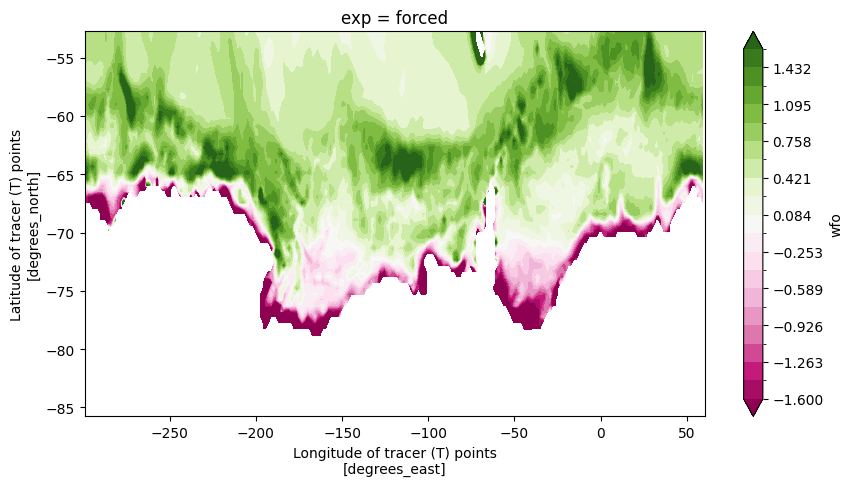

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))
fresh_ds = ds["wfo"].sum("sigma2_l").mean("time").sel(exp = "forced").isel(yh = slice(0, 60))
fresh_ds = fresh_ds * 3.154e+7 
fresh_ds = fresh_ds / 1000
fresh_ds = fresh_ds.where(np.abs(fresh_ds) > 0)
fresh_ds.plot.contourf(ax = ax, x = "geolon", y = "geolat", vmin = -1.6, vmax = 1.6, cmap = "PiYG", levels = 20)

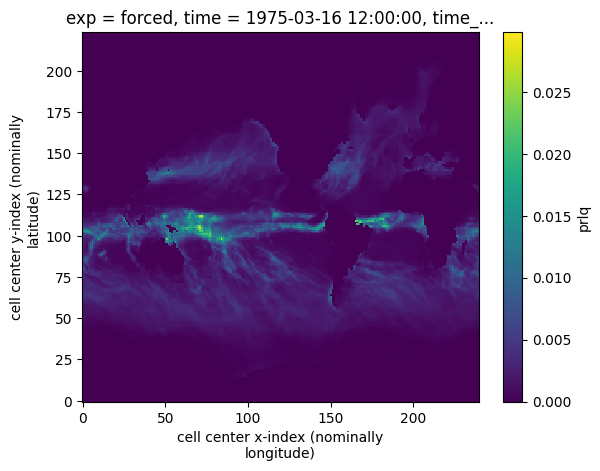

In [120]:
ds.isel(exp = 0, time = 2)["prlq"].sum("sigma2_l").where(np.abs(ds.isel(exp = 0, time = 2)))["prlq"].sum("sigma2_l").plot()

In [145]:
def get_forcing_overlap(ds_forcing_A, ds_forcing_B): 

    A_mask = xr.where(abs(ds_forcing_A.fillna(0.0)) > 0, 1, 0)
    B_mask = xr.where(abs(ds_forcing_B.fillna(0.0)) > 0, 1, 0)
    AB_mask = A_mask * B_mask

    A_only_mask = A_mask - AB_mask
    B_only_mask = B_mask - AB_mask

    return AB_mask, A_only_mask,B_only_mask 
    

In [147]:
AB_mask, A_only_mask,B_only_mask = get_forcing_overlap(ds.isel(exp = 0)["hflso"], ds.isel(exp = 1)["hflso"])

In [ ]:
#note to self, we can potentially just sum(forcing in sigma2) to create a new surface 
#forcing "file"
#then, using that file, we can use the mask from a new outcrop file (i.e., the masked forcing file of the new dataset) 
# to create a ficituous outcrop file. This should work for everything except for shortwave radiation. but that doen't
#seem to matter for the southern ocean. 

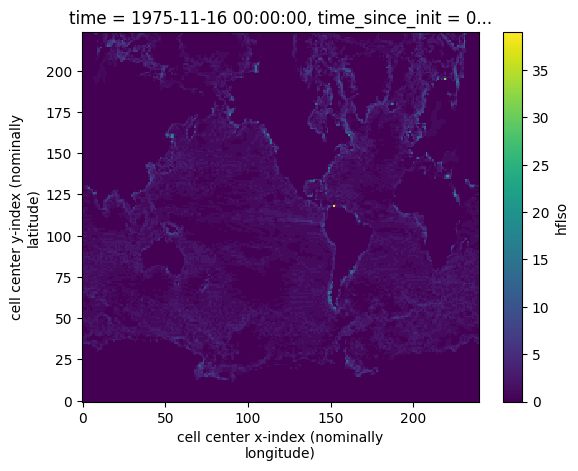

In [158]:
(A_only_mask + AB_mask).isel(time = 10).sum("sigma2_l").plot()

In [ ]:
ds.isel(exp = 0, time = 10).sel(sigma2_l = 37, method = "nearest")["hflso"].plot()

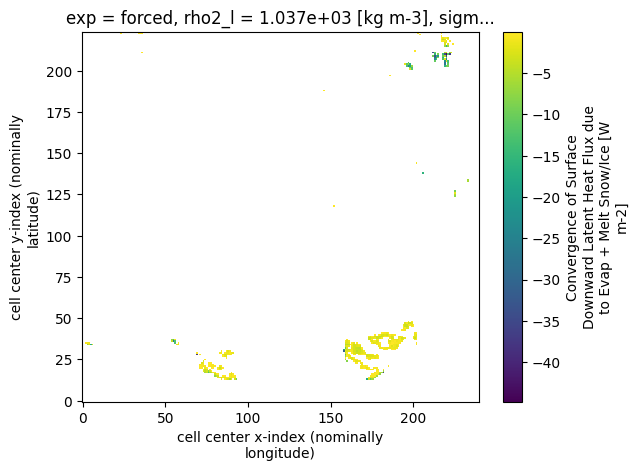

In [129]:
ds.isel(exp = 0, time = 10).sel(sigma2_l = 37, method = "nearest")["hflso"].plot()

In [ ]:
ds = ds.fillna(0.)


In [90]:
def calculate_surface_fluxes(ds):
    
    ds['mask'] = (ds['geolat'] <= -40)
    
    grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
    
    grid._ds = grid._ds.assign_coords({
        "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
        "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
    })
    grid = xwmt.add_gridcoords(
        grid,
        {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
        {"Z_target": "extend"}
    )
    
    regions = MaskRegions(ds.mask, grid).region_dict
    antarctic = regions[0] #there are more in this list if there are multiple contours 
    region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, 
                           ij=(antarctic.i, antarctic.j))
    
    with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
        
            budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
            xbudget.collect_budgets(grid, budgets_dict)
            
            wmb = xwmb.WaterMassBudget(
                grid,
                budgets_dict, 
                region,
            ) #if region not passed, the whole globe is taken
            wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                            integrate=True, along_section=False)
            
            wmt = wmb.wmt[budget_terms]
            wmt = wmt.assign_coords({"sigma2_i_target": wmb.wmt["sigma2_i_target"]})

    return wmt

In [98]:
def replace_with_climatology(ds): 
    climatology = ds.groupby("time.month").mean("time")
    return (0.0 * ds.fillna(0.0)).groupby("time.month") + climatology

def replace_all_vars_with_climatology(ds):
    ds_clim = ds.copy(deep=True)
    for var_name in ds_clim.data_vars:
        da = ds_clim[var_name]
        # Only call replace_with_climatology if “time” is one of the dimensions
        if "time" in da.dims:
            ds_clim[var_name] = replace_with_climatology(da)
        else:
            # No “time” axis → leave it as‐is
            continue

    return ds_clim
def hyopthetical_flux(ds_A, ds_B): #will replace the fluxes from 

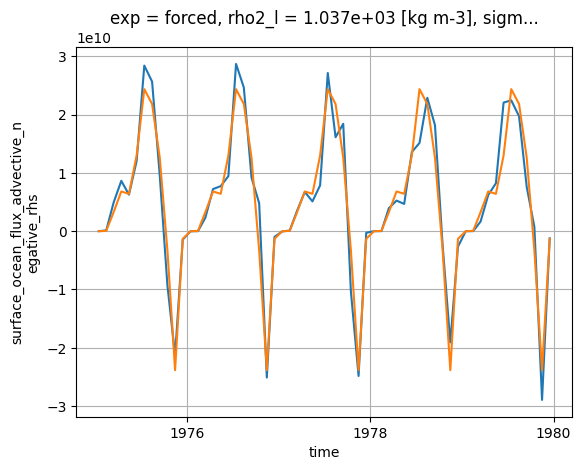

In [105]:
calculate_surface_fluxes(ds)["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0).sel(sigma2_l_target = 37, 
                                                                                            method = "nearest").plot()
calculate_surface_fluxes(replace_all_vars_with_climatology(ds))["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0).sel(sigma2_l_target = 37, 
                                                                                            method = "nearest").plot()
plt.grid()